# **SISTEMA DE DETECCION DE FRAUDE**

# Descripcion: 

El proyecto se centra en identificar solicitudes fraudulentas, como principal objetivo disminuir los Falsos Positivos sin descuidar la correcta identifiacion de solicitudes fraudulentas.
GlobalBank actualmente tiene perdidas financieras del 2.3% de los ingresos anuales por solicitudes fraudulentas. Ademas, GlobalBank tiene alta tasa de falsos positivos lo cual incrementa sus costos operacionales.


# Objetivos:
- Comprender la distribucion de variables
- Relacion de variables
- Tratamiento de variables
- Generar Hipotesis

# **EDA (Exploratory Data Analysis)**

## 1: Descripción general del conjunto de datos y estadísticas descriptivas

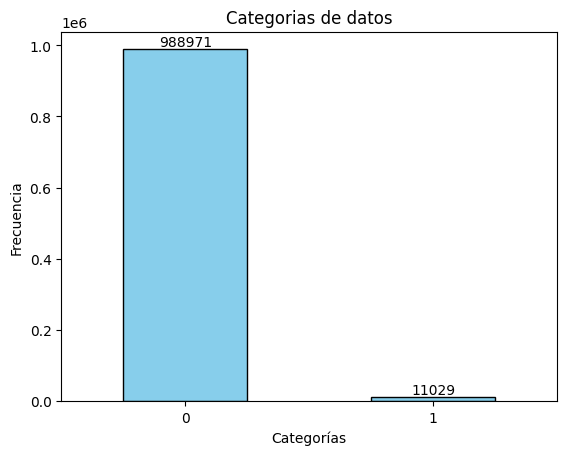

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data=pd.read_csv('gs://mit-proyect-data/Base.csv')

counts = data["fraud_bool"].value_counts()

ax = counts.plot(kind="bar", color="skyblue", edgecolor="black")
ax.bar_label(ax.containers[0])
plt.title("Categorias de datos")
plt.xlabel("Categorías")
plt.ylabel("Frecuencia")
plt.xticks(rotation=0)  # Mantener etiquetas horizontales
plt.show()

### Número de observaciones data set inicial

- **Número de observaciones:**  
  - Total de registros: **1,000,000** 
  - Cantidad de columnas: 32
- **Variable Objetivo: fraud_bool**
  - Casos no fraudulentos (`fraud_bool = 0`): **988,971** (98.9%)  
  - Casos fraudulentos (`fraud_bool = 1`): **11,029** (1.1%)  
  - Se observa un **fuerte desbalance de clases** (la clase fraude es muy minoritaria).  


In [61]:
print('--------------------------')
print('Tipos de variables del dataframe:')
print(data.dtypes.value_counts())
print('--------------------------')
print('Variables con datos vacios "null"')
nulos = data.isnull().sum().sort_values(ascending=False)
print(nulos[nulos>0].count())
print('--------------------------')

--------------------------
Tipos de variables del dataframe:
int64      18
float64     9
object      5
Name: count, dtype: int64
--------------------------
Variables con datos vacios "null"
0
--------------------------


### Variables

# 📋 Tabla de variables y decisiones de uso

| Variable                      | Descripción breve | Problemas detectados / Observaciones | Decisión recomendada |
|-------------------------------|------------------|--------------------------------------|----------------------|
| **fraud_bool**                | Etiqueta (0/1)   | Desbalance de clases (≈99% no fraude, 1% fraude). | Mantener (target) |
| **income**                    | Ingresos         | Fraudes tienen ingresos más altos (mediana 0.8 vs 0.6). | Mantener |
| **name_email_similarity**     | Similitud email-nombre | No diferencia entre fraude y no fraude. | Revisar / Posible eliminar |
| **prev_address_months_count** | Meses en domicilio anterior | Muchos `-1`, outliers, poco informativa. | Eliminar, pero se creara variable informativa dicotomica |
| **current_address_months_count** | Meses en domicilio actual | No discrimina entre fraude y no fraude. | Revisar / Posible eliminar |
| **customer_age**              | Edad por décadas | Fraudes: 30–50 años (mediana 40); No fraudes: 20–40 (mediana 30). | Mantener |
| **days_since_request**        | Días desde solicitud | Distribución plana, sin aporte. | Revisar |
| **intended_balcon_amount**    | Monto inicial    | Gran porporcion de outliers( Que significa valor negativo o positivo) | Revisar |
| **payment_type**              | Tipo de pago     | Variable categórica válida. | Mantener |
| **zip_count_4w**              | Solicitudes por código postal | Sesgada, con outliers. Puede contener señal de fraude. | Mantener (tras normalización) |
| **velocity_6h**               | Velocidad 6h     | Valores negativos, similar a velocity_24h y 4w. | Revisar (redefinir negativos / posible reducción dimensionalidad) |
| **velocity_24h**              | Velocidad 24h    | Similar a otras variables de velocidad. | Revisar (reducción dimensionalidad) |
| **velocity_4w**               | Velocidad 4w     | Similar a otras variables de velocidad. | Revisar (reducción dimensionalidad) |
| **bank_branch_count_8w**      | Solicitudes en sucursal | Distribución extrema hacia la izquierda. | Revisar (normalizar) |
| **date_of_birth_distinct_emails_4w** | Emails con misma fecha de nacimiento | Ligera tendencia en no fraude. | Mantener |
| **employment_status**         | Estado laboral   | Variable categórica válida. | Mantener |
| **credit_risk_score**         | Score de riesgo  | Inconsistencia: fraudes entre 200–300, no fraudes >300. | Mantener (revisar lógica) |
| **email_is_free**             | Email gratuito   | Variable binaria válida. | Mantener |
| **housing_status**            | Tipo de vivienda | Variable categórica válida. | Mantener |
| **phone_home_valid**          | Teléfono fijo válido | Binaria válida. | Mantener |
| **phone_mobile_valid**        | Teléfono móvil válido | Binaria válida. | Mantener |
| **bank_months_count**         | Antigüedad cuenta bancaria | Muchos `-1`, distribución limitada. | Revisar (crear dicotomica) |
| **has_other_cards**           | Tiene otras tarjetas | Binaria válida. | Mantener |
| **proposed_credit_limit**     | Límite de crédito propuesto | Fraudes tienden a tener valores más altos. | Mantener |
| **foreign_request**           | Solicitud extranjera | Binaria válida. | Mantener |
| **source**                    | Origen solicitud | INTERNET vs TELEAPP → válida. | Mantener |
| **session_length_in_minutes** | Tiempo sesión    | Muchos `-1`, outliers. | Revisar (normalizar) |
| **device_os**                 | Sistema operativo | Variable categórica válida. | Mantener |
| **keep_alive_session**        | Sesión cerrada   | Binaria válida. | Mantener |
| **device_distinct_emails_8w** | Emails distintos por dispositivo | Puede reflejar comportamiento fraudulento. | Mantener |
| **device_fraud_count**        | Fraudes previos del dispositivo | Sin variabilidad (casi todo 0). | Eliminar |
| **month**                     | Mes de la solicitud | Temporalidad, el modelo no podra entrenar con nuevos meses | Eliminar |

---

# Resumen de decisiones
- **Variables Categoricas**: \
  payment_type, employment_status, housing_status, source, device_os, month

- **Variables con [-1] representado como NaN**:\
  `prev_address_months_count`, `current_address_months_count`, `bank_months_count`, `session_length_in_minutes`, `intended_balcon_amount`, `device_distinct_emails_8w`
  
- **Eliminar:**  
  `prev_address_months_count`, `device_fraud_count`, `month`.  

- **Mantener (alto valor):**  
  `income`, `customer_age`, `proposed_credit_limit`, `credit_risk_score`, `month`, `zip_count_4w`, `date_of_birth_distinct_emails_4w`, y variables categóricas/bool relevantes.  

- **Revisar (posible tratamiento):**  
  - `velocity_6h`, `velocity_24h`, `velocity_4w` (reducción de dimensionalidad).  
  - `current_address_months_count`, `bank_months_count`, `session_length_in_minutes` (valores faltantes/outliers).  
  - `name_email_similarity` (poca diferencia entre clases, validar importancia con modelos).  


In [62]:
var_nan = ['prev_address_months_count','current_address_months_count',
           'bank_months_count','session_length_in_minutes','device_distinct_emails_8w']

data[var_nan] = data[var_nan].replace(-1, np.nan).astype('float')
data.describe()

fraud_bool          income  name_email_similarity  \
count  1000000.000000  1000000.000000         1000000.000000   
mean         0.011029        0.562696               0.493694   
std          0.104438        0.290343               0.289125   
min          0.000000        0.100000               0.000001   
25%          0.000000        0.300000               0.225216   
50%          0.000000        0.600000               0.492153   
75%          0.000000        0.800000               0.755567   
max          1.000000        0.900000               0.999999   

       prev_address_months_count  current_address_months_count  \
count              287080.000000                 995746.000000   
mean                   60.719967                     86.962058   
std                    63.578187                     88.409289   
min                     5.000000                      0.000000   
25%                    25.000000                     20.000000   
50%                    34.000000                     53.000000   
75%                    72.000000                    130.000000   
max                   383.000000                    428.000000   

         customer_age  days_since_request  intended_balcon_amount  \
count  1000000.000000        1.000000e+06          1000000.000000   
mean        33.689080        1.025705e+00                8.661499   
std         12.025799        5.381835e+00               20.236155   
min         10.000000        4.036860e-09              -15.530555   
25%         20.000000        7.193246e-03               -1.181488   
50%         30.000000        1.517574e-02               -0.830507   
75%         40.000000        2.633069e-02                4.984176   
max         90.000000        7.845690e+01              112.956928   

         zip_count_4w     velocity_6h  ...  phone_mobile_valid  \
count  1000000.000000  1000000.000000  ...      1000000.000000   
mean      1572.692049     5665.296605  ...            0.889676   
std       1005.374565     3009.380665  ...            0.313293   
min          1.000000     -170.603072  ...            0.000000   
25%        894.000000     3436.365848  ...            1.000000   
50%       1263.000000     5319.769349  ...            1.000000   
75%       1944.000000     7680.717827  ...            1.000000   
max       6700.000000    16715.565404  ...            1.000000   

       bank_months_count  has_other_cards  proposed_credit_limit  \
count      746365.000000   1000000.000000         1000000.000000   
mean           14.862618         0.222988             515.851010   
std            11.527847         0.416251             487.559902   
min             1.000000         0.000000             190.000000   
25%             1.000000         0.000000             200.000000   
50%            15.000000         0.000000             200.000000   
75%            28.000000         0.000000             500.000000   
max            32.000000         1.000000            2100.000000   

       foreign_request  session_length_in_minutes  keep_alive_session  \
count   1000000.000000              997985.000000      1000000.000000   
mean          0.025242                   7.562193            0.576947   
std           0.156859                   8.032021            0.494044   
min           0.000000                   0.000872            0.000000   
25%           0.000000                   3.117642            0.000000   
50%           0.000000                   5.122832            1.000000   
75%           0.000000                   8.878215            1.000000   
max           1.000000                  85.899143            1.000000   

       device_distinct_emails_8w  device_fraud_count           month  
count              999641.000000           1000000.0  1000000.000000  
mean                    1.019037                 0.0        3.288674  
std                     0.176700                 0.0        2.209994  
min                     0.000000                 0.0        0.00000

In [64]:
# Variables con valores NaN
nan_count = data[var_nan].isna().sum()
nan_pct = (data[var_nan].isna().sum() / len(data)) * 100
nan_summary = pd.DataFrame({
    'Cantidad NaN': nan_count,
    'Porcentaje NaN (%)': nan_pct
})
display(nan_summary)
display(data['device_fraud_count'].value_counts().reset_index())
display(data['source'].value_counts().reset_index())

Cantidad NaN  Porcentaje NaN (%)
prev_address_months_count           712920             71.2920
current_address_months_count          4254              0.4254
bank_months_count                   253635             25.3635
session_length_in_minutes             2015              0.2015
device_distinct_emails_8w              359              0.0359

device_fraud_count    count
0                   0  1000000

source   count
0  INTERNET  992952
1   TELEAPP    7048

### Datos faltantes

Luego de reemplazar la variable con los NaN correctos se oberva que la variable `prev_address_months_count` contiene 71% de valores NaN y `bank_months_count` tiene 25% de NaN.\
- Se creara una variable adicional `prev_address_valid` que representara: El cliente tiene una propiedad previa (valida = 1, no validada = 0)
- Se creara una variable adicional `prev_bank_months_count` que representara: El cliente posee una cuenta anterior con el banco (Si = 1 , No = 0)

Se elimina la variable device_fraud_count odos sus valores son 0
Se elimina la variable source porqueela categoria predominante es "INTERNET" con un 99% por tanto no aporta informacion para el modelo

In [52]:
data['prev_bank_months_count'] = np.where(data['bank_months_count'].isna(), 0, 1)
data['prev_address_valid'] = np.where(data['prev_address_months_count'] > 0,1,0)
data = data.drop(columns = ['prev_address_months_count','source','device_fraud_count','month'])

In [70]:
data['prev_address_months_count'].value_counts()

prev_address_months_count
11.0     11475
28.0     10275
29.0     10150
10.0     10082
27.0     10007
         ...  
374.0        1
5.0          1
375.0        1
383.0        1
381.0        1
Name: count, Length: 373, dtype: int64

## Paso 2: Análisis de características y visualización

### Análisis univariado

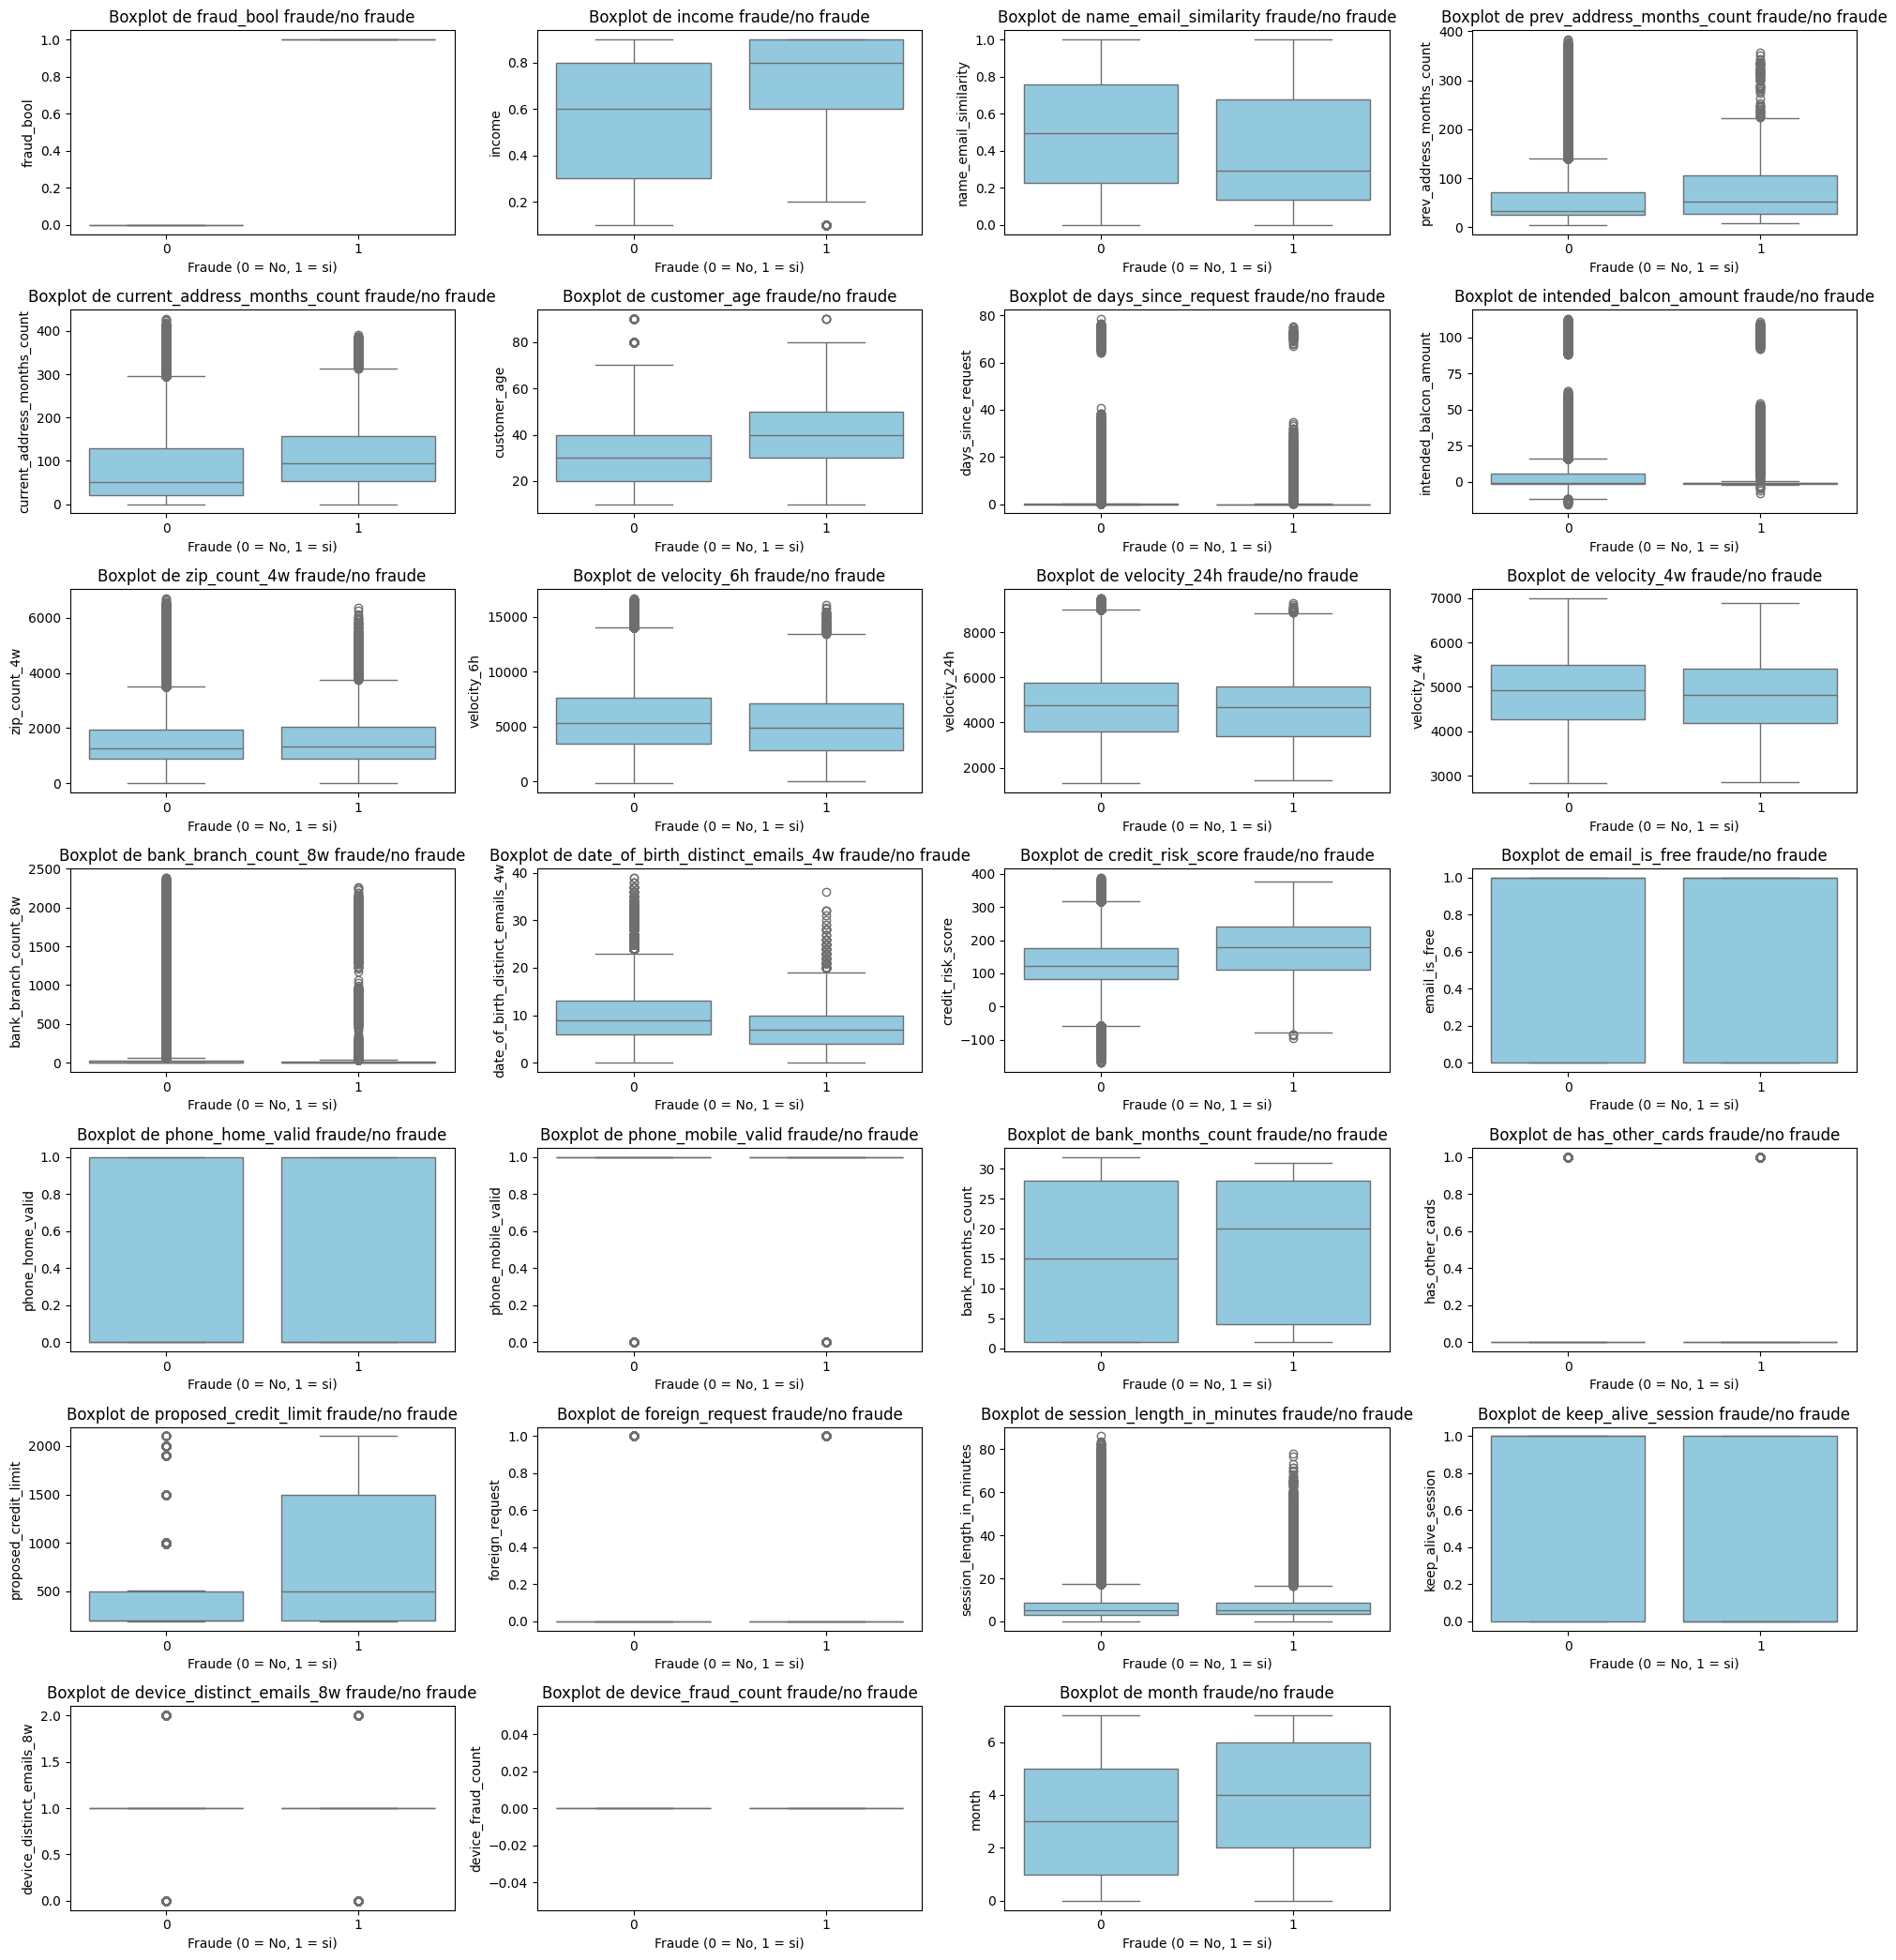

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Boxplot de variables numericas
df_num = data.select_dtypes(include='number')

n_cols = 4
n_vars = len(df_num.columns)
n_rows = math.ceil(n_vars / n_cols)

# Tamaño ajustado de figura
plt.figure(figsize=(n_cols * 5, n_rows * 3))

# Crear boxplots en múltiples columnas
for i, col in enumerate(df_num.columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x="fraud_bool", y=col, data=data, color='skyblue')
    plt.title(f"Boxplot de {col} fraude/no fraude")
    plt.xlabel("Fraude (0 = No, 1 = si)")
    plt.ylabel(col)
    plt.tight_layout()

plt.show()

- **Income (ingreso anual):**  
  - Fraude: ingresos más altos (distribución >0.6, mediana ≈0.8).  
  - No fraude: ingresos más bajos (mediana ≈0.6).  

- **Name_email_similarity:**  
  No hay diferencias notables entre fraude y no fraude.  

- **Prev_address_months_count:**  
  Alta concentración en `-1` y muchos outliers. Poco valor → se sugiere eliminarla.  

- **Current_address_months_count:**  
  No discrimina entre fraude y no fraude.  

- **Customer_age (edad):**  
  - Fraude: edades entre 30–50 años, mediana ≈40.  
  - No fraude: edades entre 20–40 años, mediana ≈30.  

- **Velocity (6h, 24h, 4w):**  
  Distribuciones similares para fraude y no fraude → poco discriminativas.  

- **Date_of_birth_distinct_emails_4w:**  
  Ligera tendencia en no fraude a coincidir más entre fecha de nacimiento y correo.  

- **Credit_risk_score:**  
  - Fraude: más común entre 200–300.  
  - No fraude: mayor a 300.  
  Se observa **inconsistencia en el score**, pues valores altos no siempre reflejan mayor riesgo.  

- **Proposed_credit_limit:**  
  Fraudes presentan límites de crédito más altos.  

- **Month:**  
  Las solicitudes realizadas en el mes 6 presentan mayor proporción de fraude.  

- **Days_since_request:**  
  No aporta información relevante → candidata a eliminación.  

- **Intended_balcon_amount:**  
  No muestra diferencias significativas → candidata a eliminación.  

- **Device_fraud_count, bank_branch_count_8w:**  
  No agregan información → candidatos a eliminación.  

### Análisis multivariado

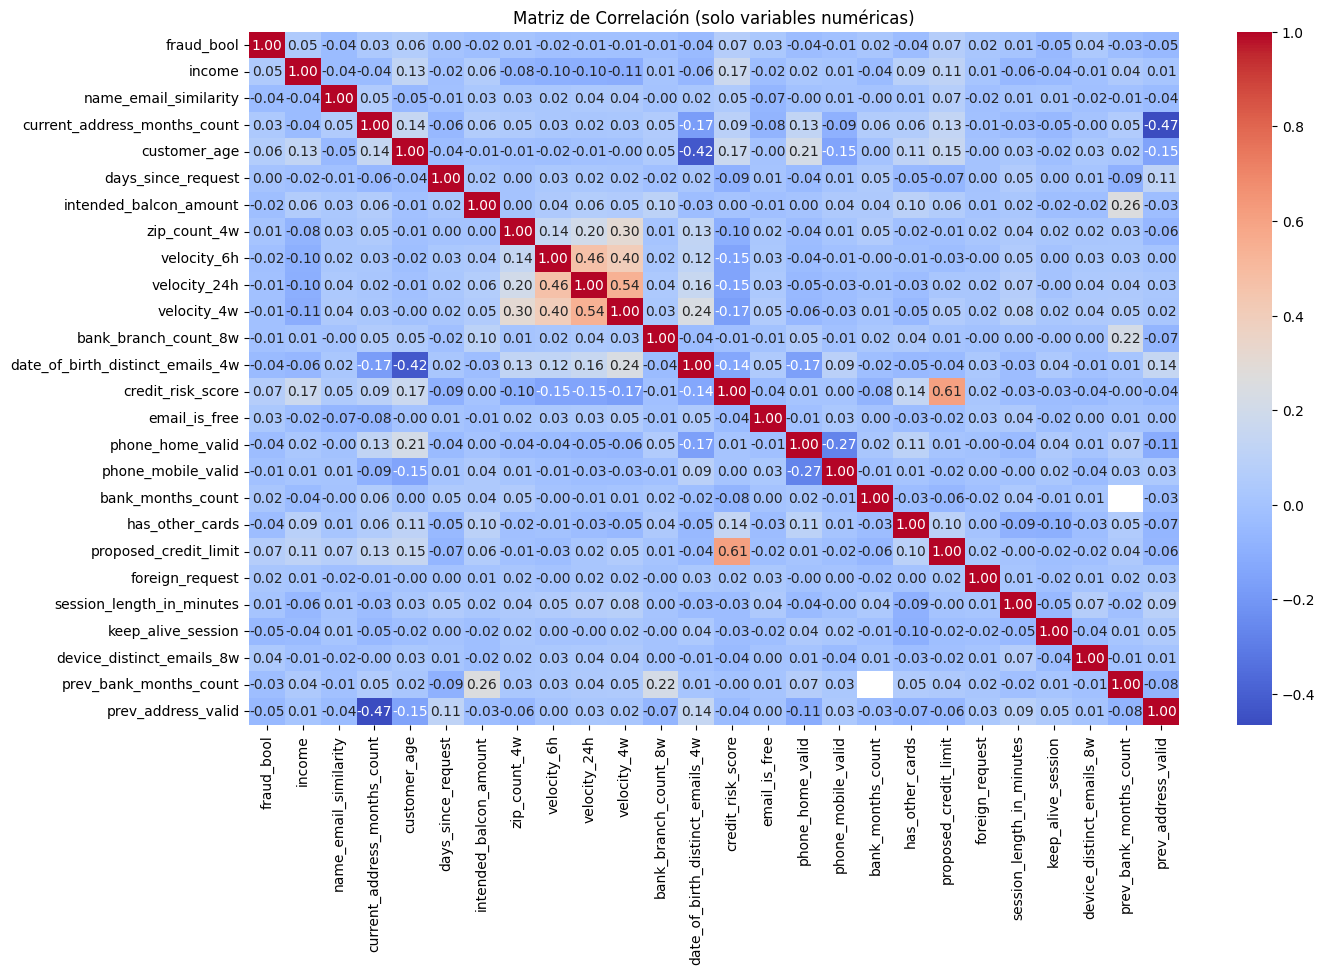

In [57]:
df_num = data.select_dtypes(include='number')
corr_matrix = df_num.corr()

plt.figure(figsize=(15, 9))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación (solo variables numéricas)")
plt.show()

- **Correlaciones:**  
  - La mayoría de las variables tienen baja correlación entre sí.  
  - `velocity_6h`, `velocity_24h`, `velocity_4w` muestran correlaciones moderadas (0.54–0.61).  
  - `credit_risk_score` aporta algo de diferenciación, aunque presenta problemas de validez.  

- **Outliers:**  
  Presentes en `prev_address_months_count`, `zip_count_4w`, `bank_branch_count_8w`, `session_length_in_minutes`.  
  Algunos pueden estar relacionados con patrones de fraude y deben analizarse antes de eliminarlos.  


### Análisis de Distribuciones

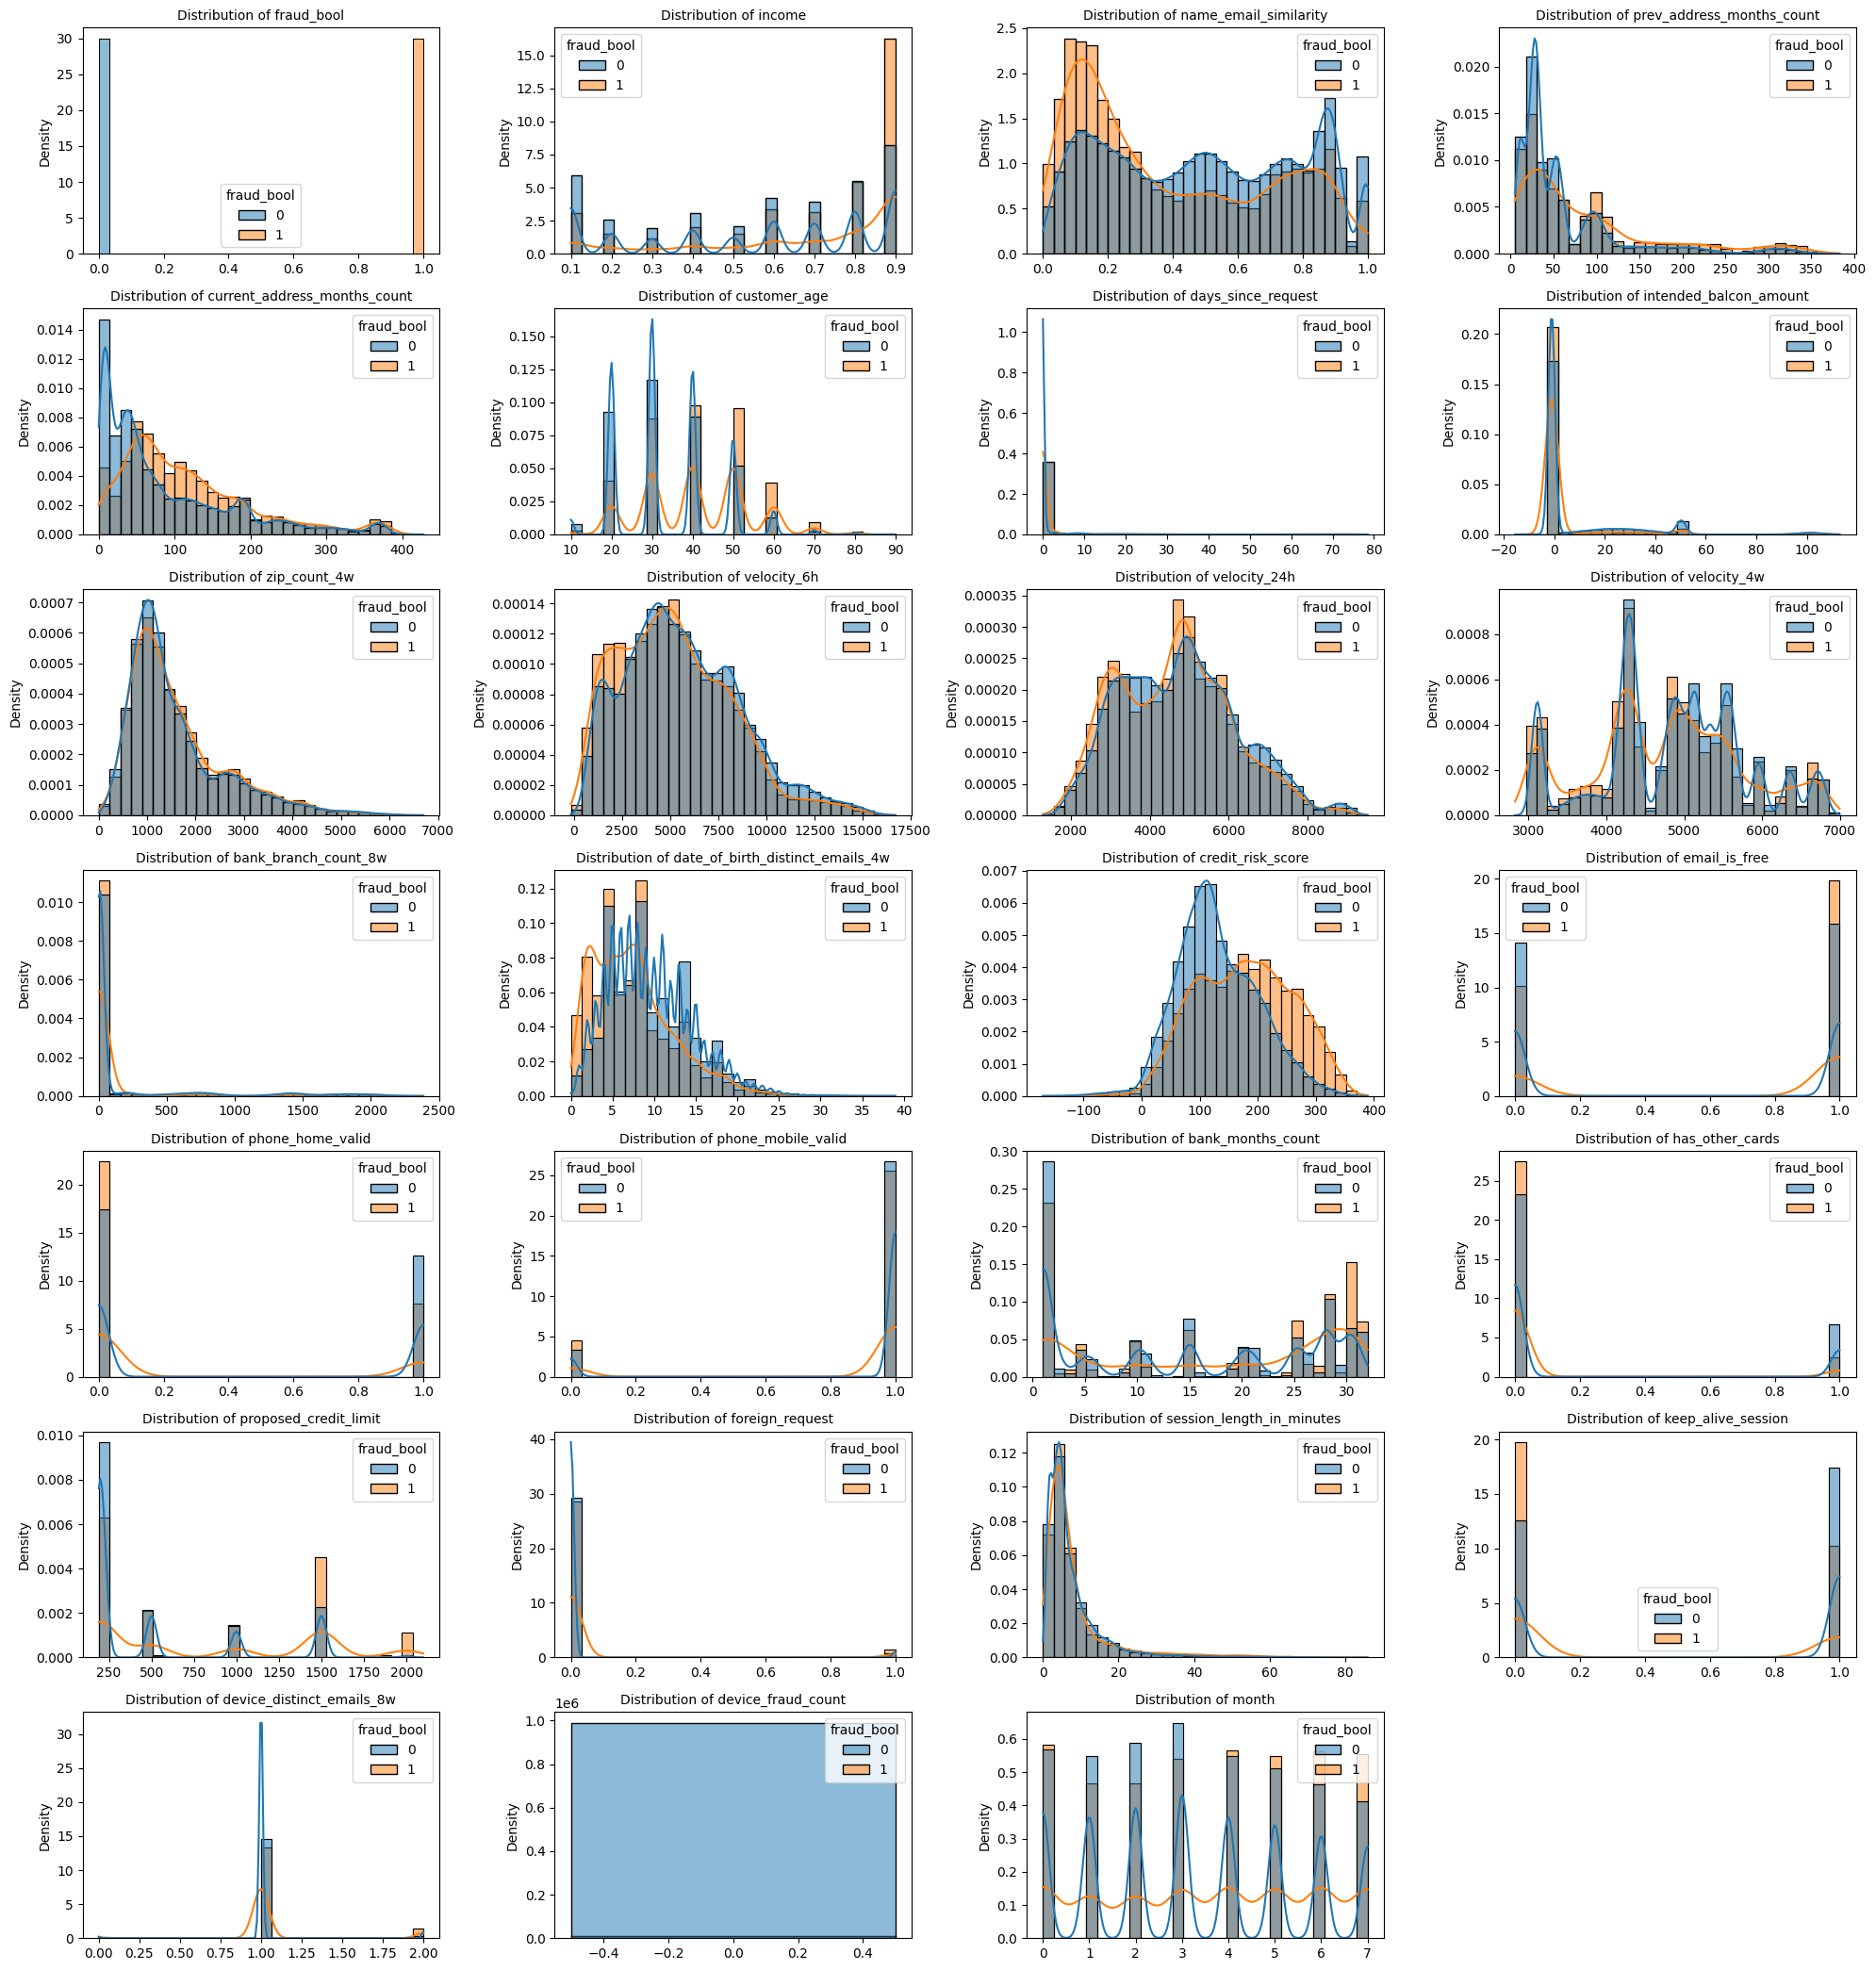

In [66]:
# Grafico de distirbuciones
df_num = data.select_dtypes(include='number')

n_cols = 4
n_vars = len(df_num.columns)
n_rows = math.ceil(n_vars / n_cols)

# Tamaño ajustado de figura
plt.figure(figsize=(n_cols * 5, n_rows * 3))

for i, col in enumerate(df_num.columns, 1):
    plt.subplot(n_rows, n_cols, i)
    
    # Solo activar kde si la variable tiene más de 1 valor distinto
    if df_num[col].nunique() > 1:
        sns.histplot(data=data, x=col, hue="fraud_bool",
                     kde=True, stat="density",
                     common_norm=False, bins=30, alpha=0.5)
    else:
        sns.histplot(data=data, x=col, hue="fraud_bool",
                     kde=False, stat="count",
                     bins=1, alpha=0.5)
    
    plt.title(f'Distribution of {col}', fontsize=10)
    plt.xlabel('')
    plt.ylabel('Density')
    plt.tight_layout()

plt.show()

- Notable desbalanceo de clases, se aplicaran tecnicas de balanceo cuando se entrene el modelo
- proposed_credit_limit, posee una distribucion sesgada con valores atipicos
- intended_balance_amount, posee una distribucion sesgada en 0-10, se debera tratar los atipicos
- session_length_in_minutes, las solicitudes fraudulentas tienen sesiones muy cortas. los valores atipicos podrian tratarse con el cuartil superior
- phone_mobile_valid, email_is_free, bank_home_valid: Fraudes se concentran más en teléfonos no válidos, emails gratuitos y direcciones no validadas.

## Paso 3: Evaluación de la calidad de los datos

### Accuracy

Los datos deben reflejar la realidad sin valores imposibles.  

- **Valores imposibles (`-1`):**  
  - `prev_address_months_count`, `current_address_months_count`, `bank_months_count`, `session_length_in_minutes`, `intended_balcon_amount`.  
  - Deben tratarse como **valores faltantes reales (`NaN`)**.  
  - `prev_address_months_count` se transformo la columna para que sea considerado si registro o no registró transformado en 1 y 0

- **Valores negativos sospechosos:**  
  - `credit_risk_score`: va de −176 a 387. Validamos que el banco asigna puntuacion negativa si tiene mayor riesgo y menor riesgo con puntuacion alta.  
  - `velocity_6h`: presenta valores negativos, lo cual **no tiene sentido físico** → Se procedio a no considerar la columna.  


### Completeness

Se refiere a la **completitud de los datos**.  

- No hay duplicados.  
- Muchas variables presentan **outliers extremos** (ej. `zip_count_4w`, `bank_branch_count_8w`, `session_length_in_minutes`).  
- Distribuciones muy sesgadas a la derecha → mayoría en valores bajos, pocos en valores altos. 
- Se aplicó transformaciones logarítmicas para reducir el efecto de outliers en `session_length_in_minutes`

### Representative

Se evalúa si los datos cumplen con reglas de negocio y formatos.  

- **Variables categóricas** (`employment_status`, `housing_status`, `payment_type`, `device_os`) → bien definidas.  
- **Variables binarias** (`email_is_free`, `phone_home_valid`, `phone_mobile_valid`, `foreign_request`) → correctas en 0/1.  
- **Variables numéricas**: algunas tienen rangos razonables, pero otras (`zip_count_4w` con valores hasta 5767) requieren validación de negocio.  


### Consistency

Los datos deben ser coherentes entre sí.  

- **Matriz de correlación:**  
  - Correlaciones bajas en general → poca redundancia.  
  - Grupo de variables `velocity_6h`, `velocity_24h`, `velocity_4w` con correlación alta (0.54–0.61) → Se evalua considerar solo 1 de estas variables.  
  - Algunas correlaciones negativas como `bank_months_count` con `current_address_months_count` (−0.27).

### Singularidad

- No se encontraron registros duplicados.  
- Variables como `device_distinct_emails_8w` y `device_fraud_count` muestran múltiples correos o fraudes por dispositivo → no son duplicados, sino indicadores útiles de fraude.  

# **Ingenieria de Variables y siguientes pasos**

## Creacion de nuevas variables

In [67]:
data['velocity_6h'] = np.where(data['velocity_6h'] <= 0,data["velocity_6h"].quantile(0.25),data["velocity_6h"])
data['ratio_velocity_6h_24h'] = data['velocity_6h']/data['velocity_24h']
data['ratio_velocity_24h_4w'] = data['velocity_24h']/data['velocity_4w']
data['income_risk_score'] = data['income']*data['credit_risk_score']

Las variables velocity estan correlacionadas y se debe tratar el valor negativo presente. Ademas se creara ratios entre ventanas para capturar el comportamiento de volumen de transacciones.
 * ratio_velocity_6h_24H -> si es mayor a 1 indica que las ultimas 6h horas hubo mayor actividad promedio por hora que las ultimas 24h
 * ratio_velocity_24h_24w -> si es mayor a 1 indica que las ultimas 24h horas hubo mayor actividad promedio por hora que las ultimas 4w
Existen clientes con score bajo pero tienen alto ingreso se creara una variable income_risk_score, para determinar los ingresos altos y sospechosos\

In [68]:
data['log_bank_branch_count_8w'] = np.log1p(data['bank_branch_count_8w'])
data['log_days_since_request'] = np.log1p(data['days_since_request'])

La variable bank_branch_count_8w contiene outliers muy grandes, sin embargo puede aportar explicabilidad para sucursales con alto volumen de transacciones. Se usara log (1+x) para escalar los valores.\
La variable log_days_since_request contiene outliers muy grandes, se aplica log(1+x) para escalar los valores y tener explicabilidad en el modelo.\

## Siguientes pasos

In [69]:
data_final = data.copy()
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 37 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         287080 non-null   float64
 4   current_address_months_count      995746 non-null   float64
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

**Hipótesis a validar con modelado**

- Clientes con historial bancario corto tienen mayor riesgo de fraude.
- Alta velocidad de transacciones y ratios de velocidad se asocia con fraude.
- Menor credit_risk_score está correlacionado con mayor fraude.

**Preparación para modelado**
- Los modelos (Random Forest, Xgboost, lightGBM) son robustos ante NaN por tanto las variables que aun posean NaN no generaran tanto ruido en los modelos.
- Dividir dataset en train/valid/test.
- Probar modelos base de clasificacion (Random Forest, Xgboost, lightGBM) como benchmark.